In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

1. Loading data.  


Renaming columns because the features were called X1–X8 and the labels were called Y1 and Y2. Column names must be descriptive, without spaces, and clearly distinguish features from labels.

In [3]:
cols = ["relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height", "orientation", "glazing_area",   
        "glazing_area_distribution", "heating_load", "cooling_load"]
dataset = pd.read_excel("energy_efficient.xlsx", names=cols)
dataset

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


1.1 Converting Data into a Classification Problem

In this Jupyter notebook, we will analyze a classification problem, so we need to convert the regression data into a classification problem using the median as the threshold.

In [4]:
threshold_heating = dataset["heating_load"].median() 
dataset["heating_load"] = (dataset["heating_load"] <= threshold_heating).astype(int)
threshold_cooling = dataset["cooling_load"].median()
dataset["cooling_load"] = (dataset["cooling_load"] <= threshold_cooling).astype(int)

1.2 Understanding the data

In [5]:
dataset_heating = dataset.iloc[:, :-1]
dataset_heating.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,1
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,1
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,1
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,1
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,0


The dataset consists of eight features and one target variable. Six features are numerical, while the remaining two are categorical and ordinal (orientation and glazing_area_distribution).

In [6]:
dataset_heating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


The dataset contains 768 entries with no missing values.

In [7]:
dataset_heating.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,0.500000
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,0.500326
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,0.000000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,0.000000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,0.500000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,1.000000
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,1.000000


1.3 Data Visualization

Boxplots show limited variability due to the synthetic and structured nature of the dataset.
Therefore, violin and scatter plots are used to better illustrate data distribution and feature–target relationships.

In [8]:
sns.set_theme(style="whitegrid", palette="muted")

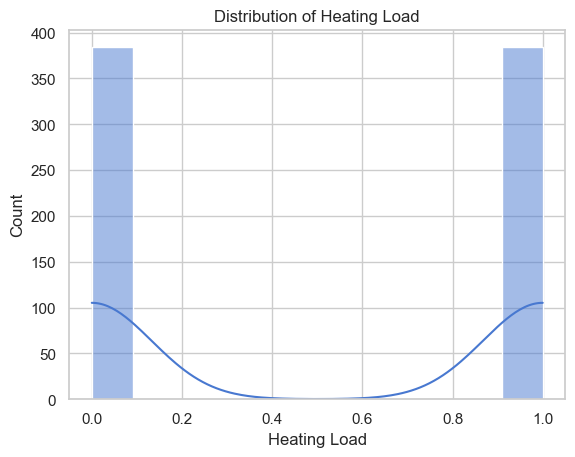

In [9]:
sns.histplot(dataset_heating["heating_load"], kde=True)
plt.title("Distribution of Heating Load")
plt.xlabel("Heating Load")
plt.show()

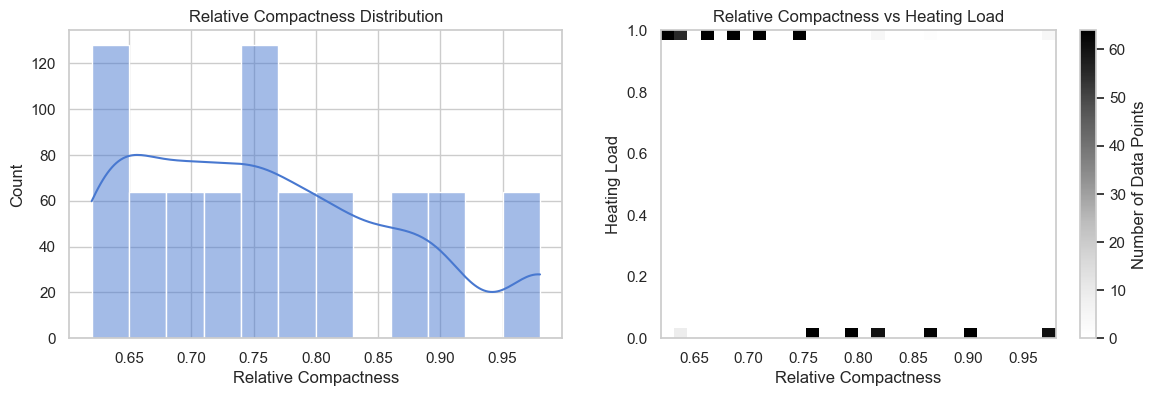

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["relative_compactness"], kde=True, ax=ax[0])
ax[0].set_title("Relative Compactness Distribution")
ax[0].set_xlabel("Relative Compactness")

h1 = ax[1].hist2d(
    x=dataset_heating["relative_compactness"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Relative Compactness")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Relative Compactness vs Heating Load")

plt.show()

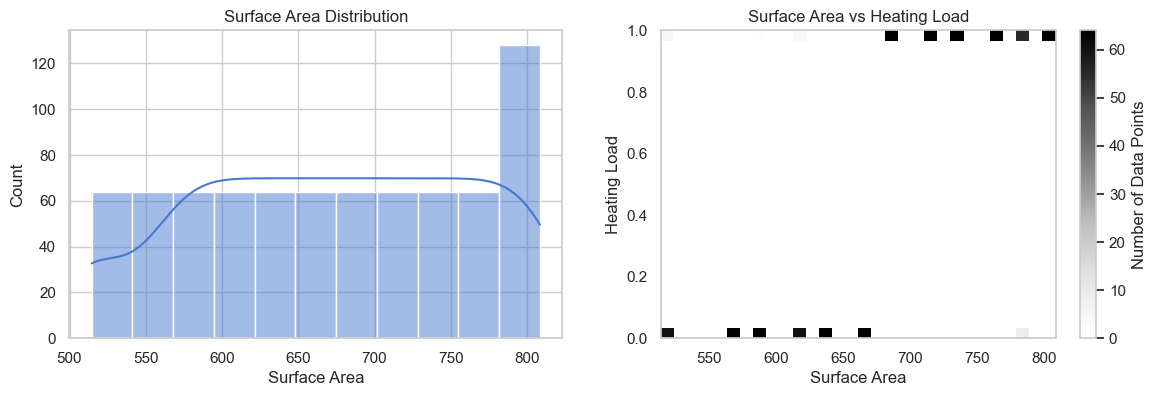

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["surface_area"], kde=True, ax=ax[0])
ax[0].set_title("Surface Area Distribution")
ax[0].set_xlabel("Surface Area")

h1 = ax[1].hist2d(
    x=dataset_heating["surface_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1])  
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Surface Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Surface Area vs Heating Load")

plt.show()

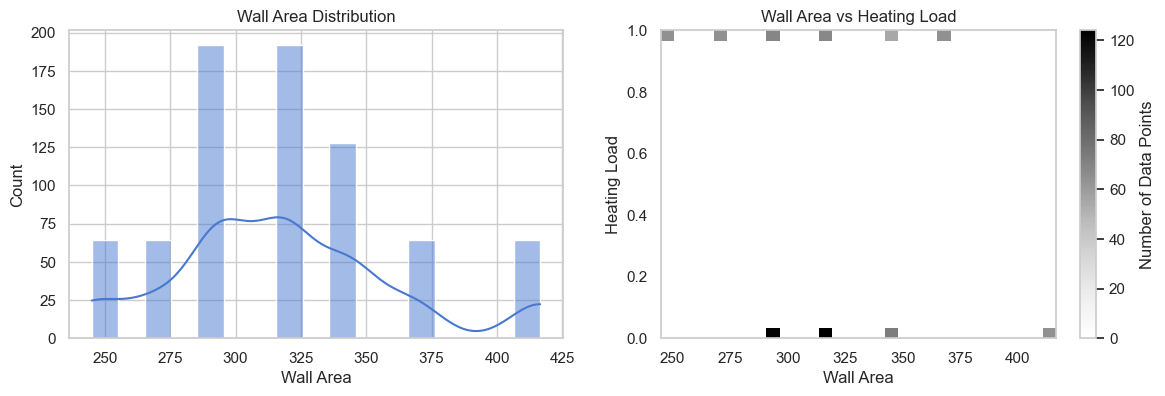

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["wall_area"], kde=True, ax=ax[0])
ax[0].set_title("Wall Area Distribution")
ax[0].set_xlabel("Wall Area")

h1 = ax[1].hist2d(
    x=dataset_heating["wall_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Wall Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Wall Area vs Heating Load")

plt.show()

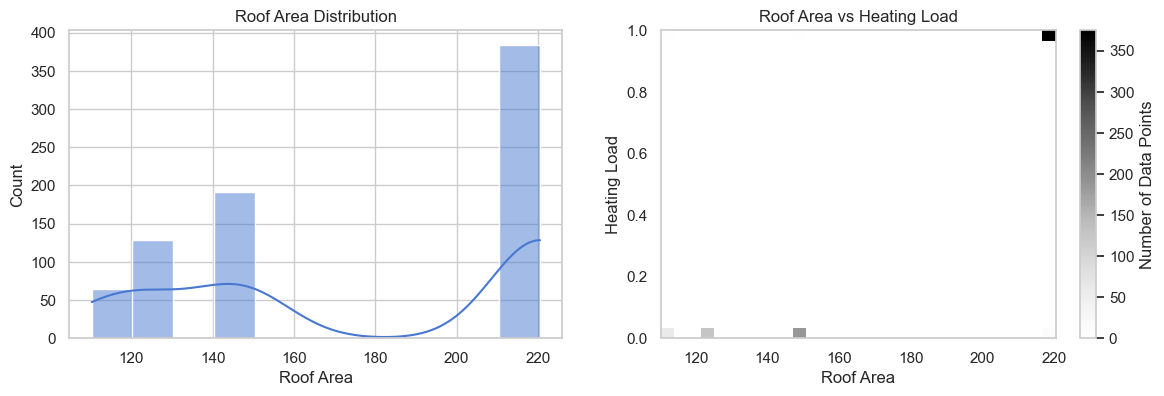

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["roof_area"], kde=True, ax=ax[0])
ax[0].set_title("Roof Area Distribution")
ax[0].set_xlabel("Roof Area")

h1 = ax[1].hist2d(
    x=dataset_heating["roof_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Roof Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Roof Area vs Heating Load")

plt.show()

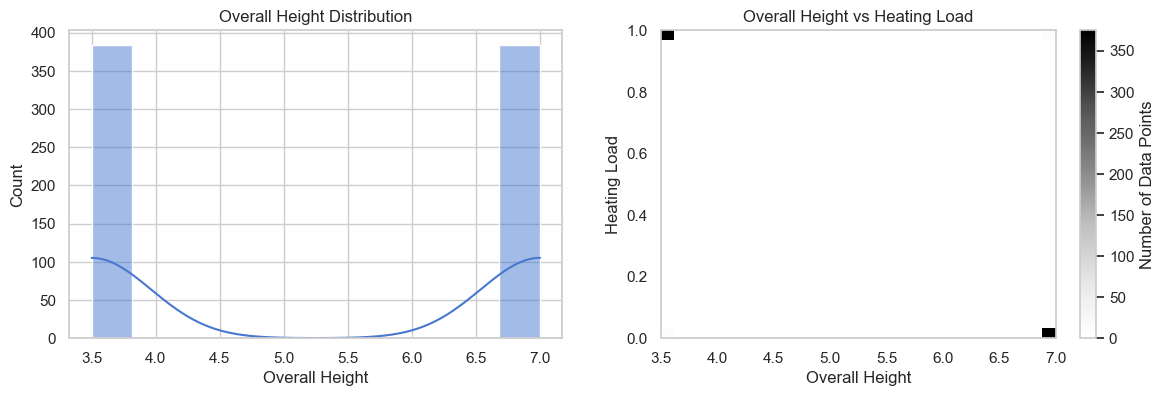

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["overall_height"], kde=True, ax=ax[0])
ax[0].set_title("Overall Height Distribution")
ax[0].set_xlabel("Overall Height")

h1 = ax[1].hist2d(
    x=dataset_heating["overall_height"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1]) 
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Overall Height")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Overall Height vs Heating Load")

plt.show()

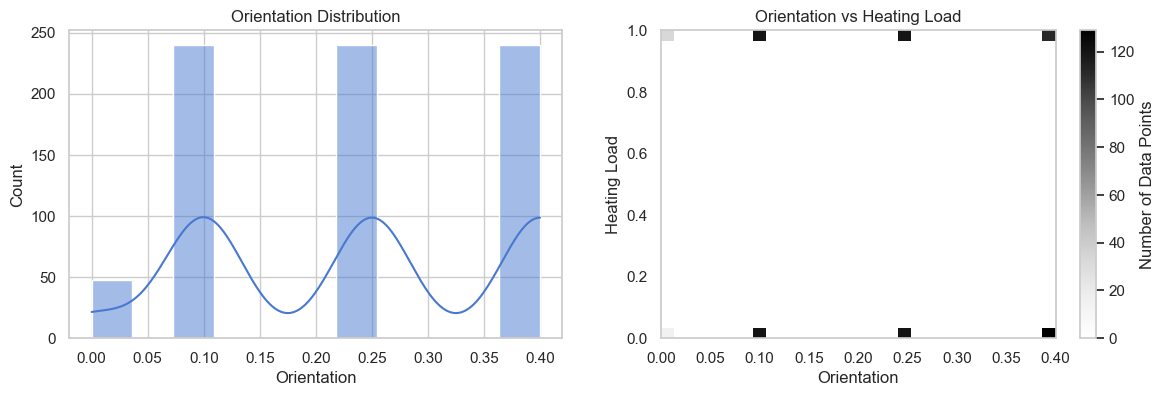

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["glazing_area"], kde=True, ax=ax[0])
ax[0].set_title("Orientation Distribution")
ax[0].set_xlabel("Orientation")

h1 = ax[1].hist2d(
    x=dataset_heating["glazing_area"],
    y=dataset_heating["heating_load"],
    bins=30,
    cmap="Greys"
)
cbar1 = fig.colorbar(h1[3], ax=ax[1])  
cbar1.set_label("Number of Data Points")
ax[1].set_xlabel("Orientation")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Orientation vs Heating Load")

plt.show()

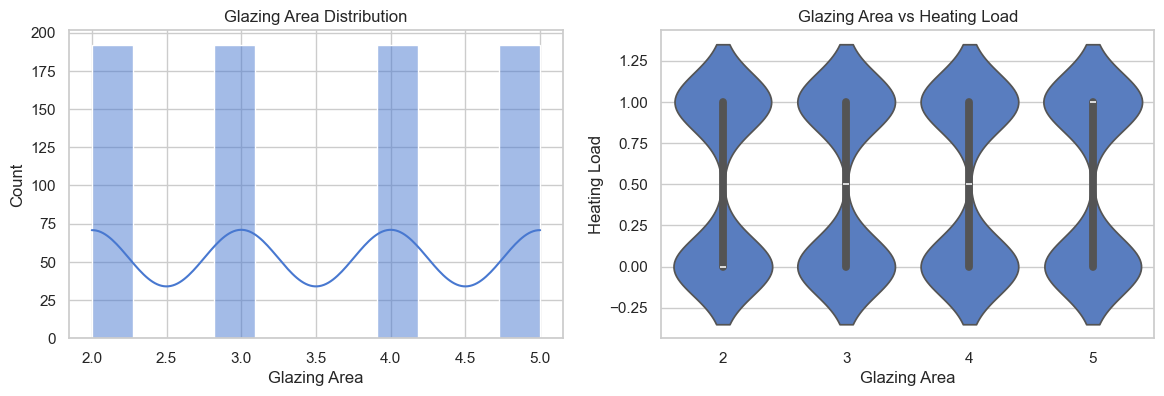

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["orientation"], kde=True, ax=ax[0])
ax[0].set_title("Glazing Area Distribution")
ax[0].set_xlabel("Glazing Area")

h1 = sns.violinplot(x="orientation", y="heating_load", data=dataset_heating, ax=ax[1])

ax[1].set_xlabel("Glazing Area")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Glazing Area vs Heating Load")

plt.show()

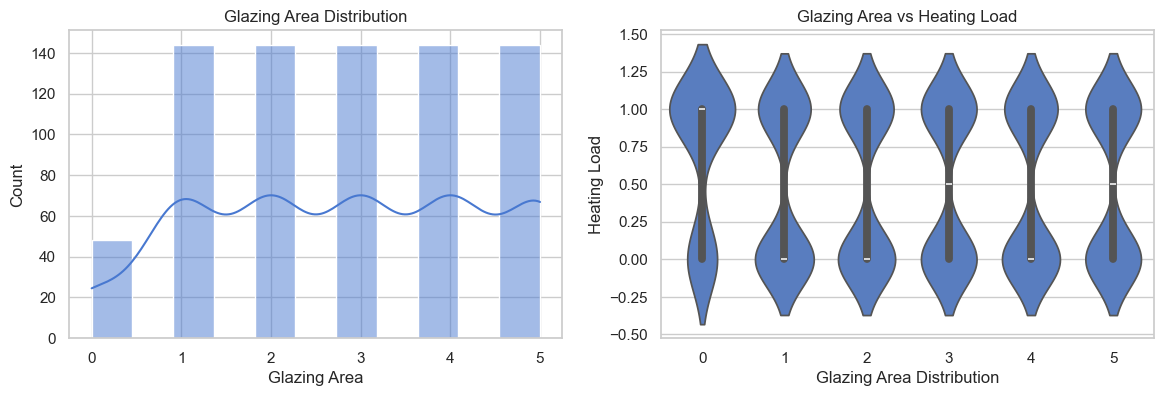

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax = ax.flatten()

sns.histplot(dataset_heating["glazing_area_distribution"], kde=True, ax=ax[0])
ax[0].set_title("Glazing Area Distribution")
ax[0].set_xlabel("Glazing Area")

h1 = sns.violinplot(x="glazing_area_distribution", y="heating_load", data=dataset_heating, ax=ax[1])

ax[1].set_xlabel("Glazing Area Distribution")
ax[1].set_ylabel("Heating Load")
ax[1].set_title("Glazing Area vs Heating Load")

plt.show()

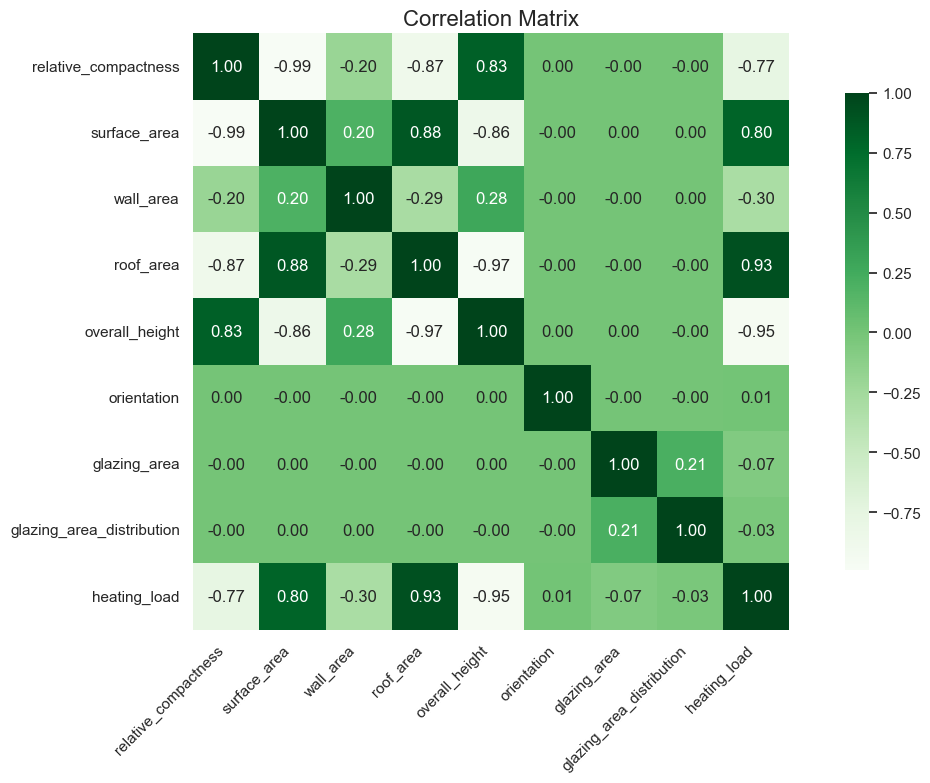

In [18]:
plt.figure(figsize=(12, 8)) 

sns.heatmap(
    dataset_heating.corr(numeric_only=True),
    cmap="Greens",
    annot=True,
    fmt=".2f",       
    square=True,      
    cbar_kws={"shrink": 0.8} 
)

plt.title("Correlation Matrix", fontsize=16) 
plt.xticks(rotation=45, ha="right")           
plt.yticks(rotation=0)                        
plt.tight_layout()
plt.show()

1.4 Data cleaning

In [19]:
dataset_heating.duplicated().sum()

np.int64(0)

In [20]:
dataset_heating.isnull().sum()

relative_compactness         0
surface_area                 0
wall_area                    0
roof_area                    0
overall_height               0
orientation                  0
glazing_area                 0
glazing_area_distribution    0
heating_load                 0
dtype: int64

In [21]:
dataset_heating.nunique()

relative_compactness         12
surface_area                 12
wall_area                     7
roof_area                     4
overall_height                2
orientation                   4
glazing_area                  4
glazing_area_distribution     6
heating_load                  2
dtype: int64

1.5 Feature Transformation 

Scaling

In [22]:
scaler = StandardScaler()

In [23]:
columns_scaled = ["relative_compactness", "surface_area", "wall_area", "roof_area", "overall_height", "glazing_area"]
dataset_scaled = dataset_heating[columns_scaled]

In [24]:
dataset_scaled

,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,0.98,514.5,294.0,110.25,7.0,0.0
1,0.98,514.5,294.0,110.25,7.0,0.0
2,0.98,514.5,294.0,110.25,7.0,0.0
3,0.98,514.5,294.0,110.25,7.0,0.0
4,0.90,563.5,318.5,122.50,7.0,0.0
...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,0.4
764,0.62,808.5,367.5,220.50,3.5,0.4
765,0.62,808.5,367.5,220.50,3.5,0.4
766,0.62,808.5,367.5,220.50,3.5,0.4


In [25]:
scaled_values = scaler.fit_transform(dataset_scaled)
dataset_scal = pd.DataFrame(scaled_values, columns=dataset_scaled.columns)
dataset_scal

,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
2,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
3,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
4,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447
...,...,...,...,...,...,...
763,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049
764,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
765,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
766,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049


In [26]:
dataset_heating = dataset_heating.drop(columns_scaled, axis=1)
dataset_heating = pd.concat([dataset_heating, dataset_scal], axis=1)

In [27]:
dataset_heating

,orientation,glazing_area_distribution,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area
0,2,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
1,3,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
2,4,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
3,5,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447
4,2,0,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447
...,...,...,...,...,...,...,...,...,...
763,5,5,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049
764,2,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
765,3,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049
766,4,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049


One-hot encoding

In [28]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
orientation_encoded = ohe.fit_transform(dataset_heating[['orientation']])
orientation_cols = ohe.get_feature_names_out(['orientation'])
orientation_dataset = pd.DataFrame(orientation_encoded, columns=orientation_cols, index=dataset_heating.index)

In [29]:
dataset_heating = dataset_heating.drop('orientation', axis=1)
dataset_heating = pd.concat([dataset_heating, orientation_dataset], axis=1)

In [30]:
dataset_heating

,glazing_area_distribution,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area,orientation_2,orientation_3,orientation_4,orientation_5
0,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,1.0,0.0,0.0,0.0
1,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,1.0,0.0,0.0
2,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,1.0,0.0
3,0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,0.0,1.0
4,0,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
763,5,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049,0.0,0.0,0.0,1.0
764,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,1.0,0.0,0.0,0.0
765,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,1.0,0.0,0.0
766,5,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,0.0,1.0,0.0


In [31]:
glazing_area_distribution_encoded = ohe.fit_transform(dataset_heating[['glazing_area_distribution']])
glazing_area_distribution_cols = ohe.get_feature_names_out(['glazing_area_distribution'])
glazing_area_distribution_dataset = pd.DataFrame(glazing_area_distribution_encoded, columns=glazing_area_distribution_cols, index=dataset_heating.index)

In [32]:
dataset_heating = dataset_heating.drop('glazing_area_distribution', axis=1)
dataset_heating = pd.concat([dataset_heating, glazing_area_distribution_dataset], axis=1)

In [33]:
dataset_heating

,heating_load,relative_compactness,surface_area,wall_area,roof_area,overall_height,glazing_area,orientation_2,orientation_3,orientation_4,orientation_5,glazing_area_distribution_0,glazing_area_distribution_1,glazing_area_distribution_2,glazing_area_distribution_3,glazing_area_distribution_4,glazing_area_distribution_5
0,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,2.041777,-1.785875,-0.561951,-1.470077,1.0,-1.760447,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0,1.284979,-1.229239,0.000000,-1.198678,1.0,-1.760447,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,1,-1.174613,1.275625,0.561951,0.972512,-1.0,1.244049,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
764,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
765,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
766,1,-1.363812,1.553943,1.123903,0.972512,-1.0,1.244049,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


1.6 Split dataset

In [34]:
X = dataset_heating.iloc[:, 1:]
y_heating = dataset["heating_load"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y_heating, test_size=0.2, random_state=42)

In [36]:
len(X_train), len(X_test), len(y_train), len(y_test)

(614, 154, 614, 154)

2. Model Selection

Algorithm: Logistic Regression!

In [37]:
lg_model_heat = LogisticRegression()
lg_model_heat.fit(X_train, y_train)
y_pred_lg_heat = lg_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_lg_heat))

acc_log = round(lg_model_heat.score(X_train, y_train) * 100, 2)
acc_log

              precision    recall  f1-score   support

           0       0.99      0.96      0.98        83
           1       0.96      0.99      0.97        71

    accuracy                           0.97       154
   macro avg       0.97      0.97      0.97       154
weighted avg       0.97      0.97      0.97       154



97.56

Algorithm: K-Nearest Neighbors (KNN)!

In [41]:
knn_model_heat = KNeighborsClassifier(n_neighbors=5)
knn_model_heat.fit(X_train, y_train)
y_pred_knn_heat = knn_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_knn_heat))

acc_knn = round(knn_model_heat.score(X_train, y_train) * 100, 2)
acc_knn

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        83
           1       0.96      1.00      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



98.37

Algorithm: Naive Bayes (NB)!

In [42]:
nb_model_heat = GaussianNB()
nb_model_heat.fit(X_train, y_train)
y_pred_nb_heat = nb_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_nb_heat))

acc_nb = round(nb_model_heat.score(X_train, y_train) * 100, 2)
acc_nb

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.97      0.99      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



97.56

Decision Tree

In [44]:
dt_model_heat = DecisionTreeClassifier()
dt_model_heat.fit(X_train, y_train)
y_pred_dt_heat = dt_model_heat.predict(X_test)
print(classification_report(y_test, y_pred_dt_heat))

acc_dt = round(dt_model_heat.score(X_train, y_train) * 100, 2)
acc_dt

              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.97      0.99      0.98        71

    accuracy                           0.98       154
   macro avg       0.98      0.98      0.98       154
weighted avg       0.98      0.98      0.98       154



100.0

Deep Learning with Pytorch!

In [46]:
X_train_nn= torch.from_numpy(X_train.values).type(torch.float32)
y_train_nn = torch.from_numpy(y_train.values).type(torch.float32)
X_test_nn= torch.from_numpy(X_test.values).type(torch.float32)
y_test_nn = torch.from_numpy(y_test.values).type(torch.float32)

In [51]:
model_nn = nn.Sequential(
    nn.Linear(in_features=16, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
)

In [52]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_nn.parameters(), lr=0.01)

In [53]:
def accurancy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc 

In [54]:
torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_nn.train()

    y_logits = model_nn(X_train_nn).squeeze()
    y_pred_nn = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train_nn)
    acc = accurancy_fn(y_true=y_train_nn, y_pred=y_pred_nn)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_nn.eval()
    with torch.inference_mode():
        test_logits = model_nn(X_test_nn).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test_nn)
        test_acc = accurancy_fn(y_true = y_test_nn, y_pred = test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc: 2f}")

Epoch: 0 | Loss: 0.70320, Acc: 26.55 | Test loss: 0.70138, Test acc:  34.415584
Epoch: 10 | Loss: 0.68469, Acc: 63.68 | Test loss: 0.68344, Test acc:  66.233766
Epoch: 20 | Loss: 0.66684, Acc: 85.99 | Test loss: 0.66601, Test acc:  83.116883
Epoch: 30 | Loss: 0.64925, Acc: 92.83 | Test loss: 0.64866, Test acc:  92.207792
Epoch: 40 | Loss: 0.63157, Acc: 96.09 | Test loss: 0.63109, Test acc:  96.753247
Epoch: 50 | Loss: 0.61349, Acc: 97.07 | Test loss: 0.61304, Test acc:  98.051948
Epoch: 60 | Loss: 0.59484, Acc: 97.39 | Test loss: 0.59435, Test acc:  98.051948
Epoch: 70 | Loss: 0.57550, Acc: 97.39 | Test loss: 0.57487, Test acc:  98.051948
Epoch: 80 | Loss: 0.55534, Acc: 97.39 | Test loss: 0.55452, Test acc:  98.051948
Epoch: 90 | Loss: 0.53439, Acc: 97.56 | Test loss: 0.53330, Test acc:  98.051948
Epoch: 100 | Loss: 0.51265, Acc: 97.56 | Test loss: 0.51126, Test acc:  98.051948
Epoch: 110 | Loss: 0.49020, Acc: 97.56 | Test loss: 0.48852, Test acc:  98.051948
Epoch: 120 | Loss: 0.46722,